In [1]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET-dev


* Rot sigma is approximately the angle at which the distribution will peak 
* Rot max is the maximum angle allowed 

Except this breaks down when rot_sigma approaches 0.1

In [3]:
from utils.noise_transforms import _expansion, _density, _score
import numpy as np
import random
import torch
from torch.nn import functional as F
import plotly.graph_objects as go
from matplotlib import pyplot as plt

In [65]:
def sample_theta(density, theta_range, score):
    sidx = np.random.randint(0, 99) # 0 is padding
    tidx = np.random.choice(list(range(100)), p=density[sidx])
    theta = theta_range[tidx]
    score = score[sidx][tidx]
    return theta, score

In [121]:
def get_theta_samples(rot_max, rot_sigma):
    theta_range = np.linspace(0.1, rot_max, 100)
    sigma_range = np.linspace(0.1, rot_sigma, 100)
    expansion = [_expansion(theta_range, sigma) for sigma in sigma_range]
    density = [_density(exp,theta_range) for exp in expansion]
    score = [_score(exp, theta_range, sigma) for exp, sigma in zip(expansion, sigma_range)]
    sampled_theta_score = [sample_theta(density, theta_range, score) for _ in range(1000)]
    sampled_theta = [x[0]*180/np.pi for x in sampled_theta_score]
    sampled_score = [x[1] for x in sampled_theta_score]
    return sampled_theta, sampled_score

Max degrees: 11.459155902616464
Sigma degrees: 2.864788975654116
Max degrees: 28.64788975654116
Sigma degrees: 14.32394487827058


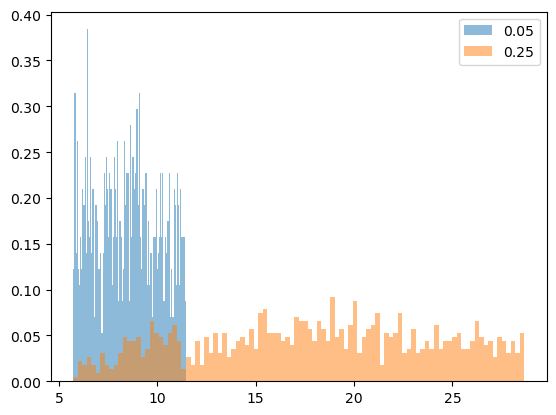

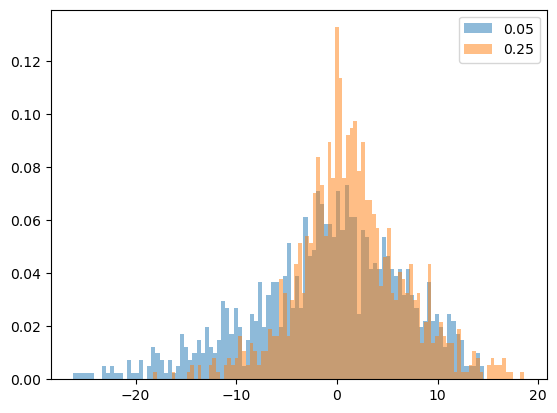

In [122]:
rot_sigmas = [0.05, 0.25]
rot_maxs = [0.2, 0.5]

sampled_thetas = []
sampled_scores = []
for rot_sigma, rot_max in zip(rot_sigmas, rot_maxs):
    print("Max degrees:", rot_max*180/np.pi)
    print("Sigma degrees:", rot_sigma*180/np.pi)
    sampled_theta, sampled_score = get_theta_samples(rot_max, rot_sigma)
    sampled_thetas.append(sampled_theta)
    sampled_scores.append(sampled_score)

for sampled_theta, rot_sigma in zip(sampled_thetas, rot_sigmas):
    plt.hist(sampled_theta, bins=100, density=True, label = rot_sigma, alpha=0.5)
plt.legend()
plt.show()

for sampled_score, rot_sigma in zip(sampled_scores, rot_sigmas):
    plt.hist(sampled_score, bins=100, density=True, label = rot_sigma, alpha=0.5)
plt.legend()
plt.show()

In [97]:
 # Extract x, y, z coordinates from the points
data1 = []
data2 = []
for sigma in sigma_range:
    x = theta_range
    y = sigma * np.ones_like(x)
    exp = _expansion(theta_range, sigma)
    density_ = _density(exp,theta_range)
    score_ = _score(exp, theta_range, sigma)

    # Create a 3D scatter plot
    data1.append(go.Scatter3d(x=x, y=y, z=score_,
                                    mode='markers',  # Use 'markers' or 'lines' depending on the desired output
                                    marker=dict(
                                        size=2,  # Adjust marker size for better visibility
                                        color=score_,  # Color the markers by their z-coordinate for depth effect
                                        colorscale='Viridis',  # Choose a color scale
                                        opacity=0.8  # Adjust opacity
                                    )))
    # Create a 3D scatter plot
    data2.append(go.Scatter3d(x=x, y=y, z=density_,
                                    mode='markers',  # Use 'markers' or 'lines' depending on the desired output
                                    marker=dict(
                                        size=2,  # Adjust marker size for better visibility
                                        color=density_,  # Color the markers by their z-coordinate for depth effect
                                        colorscale='Viridis',  # Choose a color scale
                                        opacity=0.8  # Adjust opacity
                                    )))
fig = go.Figure(data=data1)
fig.show()
fig = go.Figure(data=data2)
fig.show()

## Rotation Noise

What does this distribution look like? It is a N SO(3) distribution with one parameter, noise level (sigma).
* For small sigma the distribution peaks at theta = 0
* For medium sigma 0 < sigma < 1, the distribution is bimodal with peaks closer to theta = 0 and theta = pi
* For large sigma > 1 the distribution peaks at theta = pi

By restricting sigma and theta ranges you reduce what part of the distribution you are sampling from

Translation here is a 3D vector sampled from a normal distribution, scaled by a uniformly sampled eps.

When the model predicts `wloss = self.mse_loss(rot_noise, hat_w * score)`

The loss is given by $$\ell_r = \mathbb{E}\left[\left\|\tilde{\omega} - \nabla_\omega \log p(\omega)\right\|^2\right]$$

For the rotation DSM, we sample random rotation $\omega = \hat{\omega}\cdot\theta$. As $\hat{\omega}$ is sampled from a uniform distribution over a sphere (whose density is constant), the density and score of $p(\omega)$ is

$$
p(\omega) \propto f(\theta), \quad \nabla_\omega \log p(\omega) = \nabla_\omega \log f(\theta) \cdot \hat{\omega}
$$

In practice, we calculate the density and score by precomputing truncated infinite series in $f(\theta)$.

See https://www.biorxiv.org/content/10.1101/2023.12.10.570461v1.full.pdf page 16

## Translation Noise

Translation loss in themodel is given by `tloss = self.mse_loss(trans_noise * eps, -hat_t / eps)`

Here `hat_t` is a vector sampled from a normal distribution, and `eps` is a scalar sampled from a uniform distribution. The translation loss is given by 
$$\ell_t = \mathbb{E}\left[\|\hat{t} - \nabla_t \log p(t)\|^2\right]$$
where $\nabla_t \log p(t) = -t/\sigma^2$ since $t$ follows a normal distribution with variance $\sigma^2$.

## Atom noise

Atom noise is given by `atom_noise = torch.clamp(torch.randn_like(Z), min=-1, max=1)` and atom loss is just `self.mse_loss(pred_noise, atom_noise)`. This is the same as the translation noise, but `\sigma = 1` always. TODO: we could updated this so it is not always sigma = 1.

## Can this be used as a denoising model?
Because it is learning a score function, there is not easy way to map back to the original distribution. However, using iterative sampling and Langevin MCMC you could?

In [16]:
batch_size = 8

sidx = [random.randint(0, 99) for _ in range(batch_size)]  # picks the sigma index
tidx = [np.random.choice(list(range(100)), p=density[i]) for i in sidx] # given the probability density from the sigma index it chooses the theta index
theta = torch.tensor([theta_range[i] for i in tidx]).float() # [batch_size]
w = torch.randn(batch_size, 3)
hat_w = F.normalize(w, dim=-1)
w = hat_w * theta.unsqueeze(-1) # [batch_size,3]
eps = np.random.uniform(0.1, 1.0, size=batch_size)
eps = torch.tensor(eps).float().unsqueeze(-1)
hat_t = torch.randn(batch_size, 3) * eps

In [12]:
# Number of points
n_points = 100

# Points will form a line in the z direction, centered at (0, 0, 0)
# Generate points from -n_points/2 to n_points/2 in the z-axis
z = torch.linspace(-n_points/2, n_points/2, n_points)

# x and y coordinates are 0 to keep the line along the z-axis
x = torch.zeros(n_points)
y = torch.zeros(n_points)

# Combine x, y, and z to form a set of 3D points
points = torch.stack((x, y, z), dim=1)

In [18]:
def visualise_points(points):
    # Convert the tensor to numpy for easy handling with Plotly
    points_np = points.numpy()

    # Extract x, y, z coordinates from the points
    x = points_np[:, 0]
    y = points_np[:, 1]
    z = points_np[:, 2]

    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',  # Use 'markers' or 'lines' depending on the desired output
                                    marker=dict(
                                        size=2,  # Adjust marker size for better visibility
                                        color=z,  # Color the markers by their z-coordinate for depth effect
                                        colorscale='Viridis',  # Choose a color scale
                                        opacity=0.8  # Adjust opacity
                                    ))])
    fig.show()

In [17]:
c = w.norm(dim=-1, keepdim=True)  # [B, 1]
c1 = torch.sin(c) / c.clamp(min=1e-6) # [B, 1]
c2 = (1 - torch.cos(c)) / (c ** 2).clamp(min=1e-6) # [B, 1]

i = 0
wi = w[i].unsqueeze(0)  # [1, 3]
new_points = points + c1[i] * torch.cross(wi, points) + c2[i] * torch.cross(wi, torch.cross(wi, points))

In [19]:
visualise_points(points)

In [20]:
visualise_points(new_points)

In [24]:
torch.norm(new_points[0] - new_points[-1], dim=-1)

tensor(100.)

In [25]:
torch.norm(points[0] - points[-1], dim=-1)


tensor(100.)

In [39]:
w_score = torch.tensor([score[i][j] for i,j in zip(sidx, tidx)]).float()
noise_w = hat_w * w_score.unsqueeze(-1)

IndexError: index 49 is out of bounds for dimension 0 with size 8

In [27]:
noise_w

tensor([[ 2.1541,  3.7406, -2.9762],
        [ 3.7845,  1.0720, -1.6443],
        [-3.0369,  0.5735,  2.2898],
        [-0.1856, -0.5935, -3.6376],
        [-1.6940,  0.8091,  2.5941],
        [-0.5354,  3.2377, -0.0285],
        [-1.4519, -1.5257, -1.7364],
        [ 3.4110,  0.0580, -2.0121]])